# This is a notebook for Fig. 3 in Albright et al. in prep.

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import shapely.geometry as sgeom
import xarray as xr
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## Calculating diurnal cycle of CAPE in NAM region

In [2]:
path = "/glade/derecho/scratch/malbright/FROM_CHEYENNE/remap/"
plio_cape = xr.open_dataset(path + "Plio_CAPE_regional.nc").CAPE
pi_cape = xr.open_dataset(path + "PI_CAPE_regional.nc").CAPE

In [3]:
def is_jj(month):
    return (month >= 6) & (month <= 7)

In [4]:
minlat = 25
maxlat = 27
minlon = 254
maxlon = 255

# read in data and convert to local time
plio_lr_cape = (
    xr.open_mfdataset(
        path + "plio/b.e13.B1850C5CN.ne30_g16.plio.001.cam.h4.CAPE.*.remap.nc"
    )
    .sel(lat=slice(minlat, maxlat))
    .sel(lon=slice(minlon, maxlon))
    .CAPE
    .load()
)

plio_lr_cape = plio_lr_cape.sel(time=is_jj(plio_lr_cape['time.month']))

plio_lr_cape["time"] = plio_lr_cape.time.get_index("time").shift(-7, "H")

In [5]:
# read in data and convert to local time
pi_lr_cape = (
    xr.open_mfdataset(
        path + "pi/b.e13.B1850C5CN.ne30_g16.pi.001.cam.h4.CAPE.*.remap.nc"
    )
    .sel(lat=slice(minlat, maxlat))
    .sel(lon=slice(minlon, maxlon))
    .CAPE
    .load()
)

pi_lr_cape = pi_lr_cape.sel(time=is_jj(pi_lr_cape['time.month']))

pi_lr_cape["time"] = pi_lr_cape.time.get_index("time").shift(-7, "H")

In [6]:
def process_boxplots(ds):
    # set data for boxplots
    ds_data = [
        ds.isel(time=(ds.time.dt.hour == 2)).values.flatten(),
        ds.isel(time=(ds.time.dt.hour == 5)).values.flatten(),
        ds.isel(time=(ds.time.dt.hour == 8)).values.flatten(),
        ds.isel(time=(ds.time.dt.hour == 11)).values.flatten(),
        ds.isel(time=(ds.time.dt.hour == 14)).values.flatten(),
        ds.isel(time=(ds.time.dt.hour == 17)).values.flatten(),
        ds.isel(time=(ds.time.dt.hour == 20)).values.flatten(),
        ds.isel(time=(ds.time.dt.hour == 23)).values.flatten(),
    ]

    return ds_data

In [7]:
# set data for boxplots
plio_data = process_boxplots(plio_cape)
pi_data = process_boxplots(pi_cape)

In [8]:
# set data for boxplots
plio_lr_data = process_boxplots(plio_lr_cape)
pi_lr_data = process_boxplots(pi_lr_cape)

## Calculating diurnal cycle of MCSs in NAM region

In [9]:
# read in data and convert to local time
path = "/glade/work/malbright/final_nam_manuscript_files/mcs/pliocene/"
plio = (
    xr.open_dataset(
        path
        + "mcs_tracks_Plio_global.nc"
    )
    .sel(lat=slice(minlat, maxlat))
    .sel(lon=slice(minlon, maxlon))
)

plio = plio.sel(time=is_jj(plio['time.month']))

plio["time"] = plio.time.get_index("time").shift(-7, "H")

In [10]:
path = (
    "/glade/work/malbright/final_nam_manuscript_files/mcs/preindustrial/"
)
pi = (
    xr.open_mfdataset(path + "mcs_tracks_PI_global_pt*_JJ.nc")
    .sel(lat=slice(minlat, maxlat))
    .sel(lon=slice(minlon, maxlon))
    .load()
)

pi = pi.sel(time=is_jj(pi['time.month']))

pi["time"] = pi.time.get_index("time").shift(-7, "H")

In [11]:
# make binary
plio_binary = xr.where(plio > 0, 1, 0)
pi_binary = xr.where(pi > 0, 1, 0)

# group by hour and take sum
plio_sum = plio_binary.groupby("time.hour").sum(dim="time")
pi_sum = pi_binary.groupby("time.hour").sum(dim="time")

# divide by number of years
plio_avg = plio_sum / 26
pi_avg = pi_sum / 12

# average over lat/lon & take st dev
plio_diurnal_avg = plio_avg.mean(dim="lat").mean(dim="lon")
pi_diurnal_avg = pi_avg.mean(dim="lat").mean(dim="lon")

plio_diurnal_std = plio_avg.std(dim="lat").std(dim="lon")
pi_diurnal_std = pi_avg.std(dim="lat").std(dim="lon")

# get lower and upper bounds for st dev
pi_lower_mcs = pi_diurnal_avg - pi_diurnal_std
pi_upper_mcs = pi_diurnal_avg + pi_diurnal_std

plio_lower_mcs = plio_diurnal_avg - plio_diurnal_std
plio_upper_mcs = plio_diurnal_avg + plio_diurnal_std

## Panel plot:

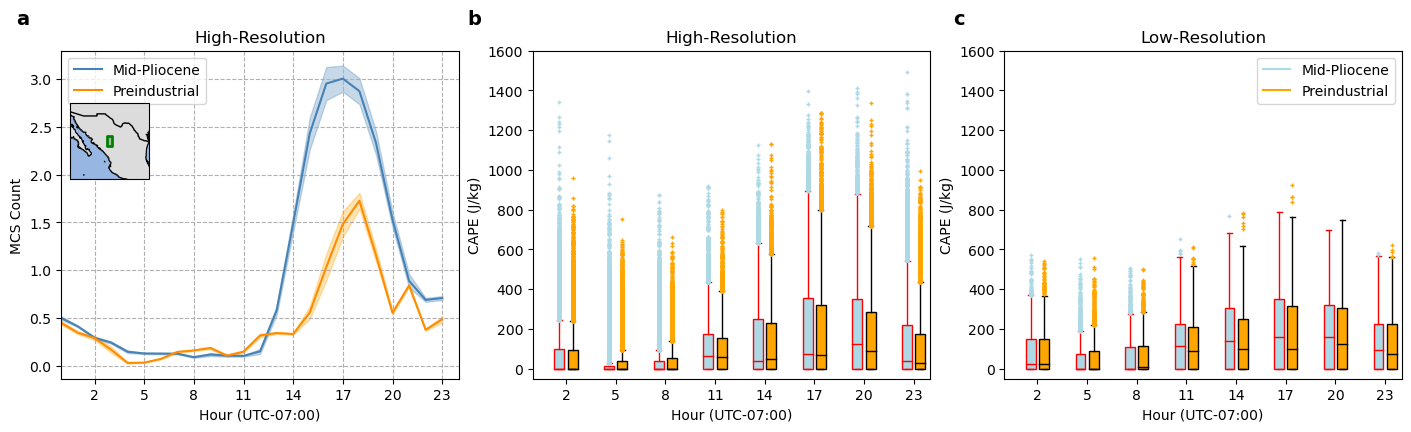

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)
###################################################
# MCS DIURNAL CYCLE
###################################################

# Retrieve xticks from the first plot (ax1)
xticks = [2, 5, 8, 11, 14, 17, 20, 23]

ax1 = axes[0]
ax1.plot(
    plio_diurnal_avg.hour,
    plio_diurnal_avg.MCS_PRECT.values,
    color="steelblue",
    label="Mid-Pliocene",
)
ax1.plot(
    pi_diurnal_avg.hour,
    pi_diurnal_avg.MCS_PRECT.values,
    color="darkorange",
    label="Preindustrial",
)
ax1.fill_between(
    plio_diurnal_avg.hour,
    plio_lower_mcs.MCS_PRECT.values,
    plio_upper_mcs.MCS_PRECT.values,
    color="steelblue",
    alpha=0.3,
)
ax1.fill_between(
    pi_diurnal_avg.hour,
    pi_lower_mcs.MCS_PRECT.values,
    pi_upper_mcs.MCS_PRECT.values,
    color="orange",
    alpha=0.3,
)
ax1.legend(loc="upper left")
ax1.set_ylabel("MCS Count")
ax1.set_xticks(xticks)
ax1.set_xlim(0, 24)
ax1.set_xlabel("Hour (UTC-07:00)")
ax1.grid(ls="--")
ax1.set_title("High-Resolution")

###################################################
# ADD INSET MAP
###################################################
minlat = 25
maxlat = 27
minlon = 254
maxlon = 255

lon_bounds = [minlon, maxlon]
lat_bounds = [minlat, maxlat]
extends = 7
bounds = [lon_bounds[0], lon_bounds[1] - 0.1, lat_bounds[0], lat_bounds[1]]
map_extent = [
    bounds[0] - (extends + 1),
    bounds[1] + (extends + 1),
    bounds[2] - extends,
    bounds[3] + extends,
]
inset_param = {"width": "20%", "height": "50%", "loc": "upper left", "borderpad": 0.6}

resolution = "110m"
land = cfeature.NaturalEarthFeature("physical", "land", resolution)
ocean = cfeature.NaturalEarthFeature("physical", "ocean", resolution)
proj = ccrs.PlateCarree(central_longitude=180)
box_proj = ccrs.PlateCarree(central_longitude=0)
sub_ax = inset_axes(
    ax1,
    width=inset_param["width"],
    height=inset_param["height"],
    loc=inset_param["loc"],
    axes_class=GeoAxes,
    borderpad=inset_param["borderpad"],
    axes_kwargs=dict(projection=proj),
)

sub_ax.set_extent(map_extent, crs=box_proj)
# Add land, coastlines, borders to inset
sub_ax.add_feature(land, facecolor="gainsboro")
sub_ax.add_feature(
    ocean, edgecolor="none", facecolor=cfeature.COLORS["water"], zorder=0
)
sub_ax.add_feature(land, facecolor="none", zorder=1)
sub_ax.add_feature(cfeature.BORDERS, zorder=2)
sub_ax.add_feature(cfeature.COASTLINE, zorder=2, lw=0.7)
# Plot a box region in the inset
box = sgeom.box(
    minx=lon_bounds[0] - 360,
    maxx=lon_bounds[1] - 360,
    miny=lat_bounds[0],
    maxy=lat_bounds[1],
)
sub_ax.add_geometries(
    [box], box_proj, facecolor="none", edgecolor="green", lw=2, zorder=3
)
sub_ax.add_geometries(
    [box], box_proj, facecolor="g", edgecolor="none", alpha=0.3, zorder=3
)

###################################################
### CAPE DIURNAL CYCLE -- HR
###################################################
xticks = ax1.get_xticks()

ax3 = axes[1]

plio_color = "lightblue"
pi_color = "orange"

flierprops_plio = dict(
    marker=".", markerfacecolor=plio_color, markeredgecolor=plio_color, markersize=3
)
flierprops_pi = dict(
    marker=".", markerfacecolor=pi_color, markeredgecolor=pi_color, markersize=3
)
# Adjust the positions of the boxplot to match the xticks
bpl = ax3.boxplot(
    plio_data,
    positions=np.array(xticks) - 0.4,  # Shift left slightly
    sym="+",
    widths=0.6,
    flierprops=flierprops_plio,
    patch_artist=True,
    boxprops=dict(facecolor=plio_color),
)
bpr = ax3.boxplot(
    pi_data,
    positions=np.array(xticks) + 0.4,  # Shift right slightly
    sym="+",
    widths=0.6,
    flierprops=flierprops_pi,
    patch_artist=True,
    boxprops=dict(facecolor=pi_color),
)


def set_box_color(bp, edge_color, color):
    for element in ["boxes", "whiskers", "fliers", "means", "medians", "caps"]:
        plt.setp(bp[element], color=edge_color)

    for patch in bp["boxes"]:
        patch.set(facecolor=color)


set_box_color(bpl, "red", plio_color)
set_box_color(bpr, "black", pi_color)

# draw temporary orange and blue lines and use them to create a legend
ax3.plot([], c=plio_color, label="Mid-Pliocene")
ax3.plot([], c=pi_color, label="Preindustrial")
# ax3.legend(loc="upper left")

# Set the xticks of ax3 to match ax1
ax3.set_xticks(xticks)
ax3.set_xticklabels(
    [int(tick) for tick in xticks]
)  # Optional: format the tick labels if needed
ax3.set_xlim(ax1.get_xlim())  # Ensure the same x-axis limits as ax1
ax3.set_ylim(-50, 1600)
ax3.set_xlabel("Hour (UTC-07:00)")
ax3.set_ylabel("CAPE (J/kg)")
ax3.set_title("High-Resolution")

###################################################
### CAPE DIURNAL CYCLE -- LR
###################################################
xticks = ax1.get_xticks()

ax4 = axes[2]

# Adjust the positions of the boxplot to match the xticks
bpl_lr = ax4.boxplot(
    plio_lr_data,
    positions=np.array(xticks) - 0.4,  # Shift left slightly
    sym="+",
    widths=0.6,
    flierprops=flierprops_plio,
    patch_artist=True,
    boxprops=dict(facecolor=plio_color),
)
bpr_lr = ax4.boxplot(
    pi_lr_data,
    positions=np.array(xticks) + 0.4,  # Shift right slightly
    sym="+",
    widths=0.6,
    flierprops=flierprops_pi,
    patch_artist=True,
    boxprops=dict(facecolor=pi_color),
)

set_box_color(bpl_lr, "red", plio_color)
set_box_color(bpr_lr, "black", pi_color)

# draw temporary orange and blue lines and use them to create a legend
ax4.plot([], c=plio_color, label="Mid-Pliocene")
ax4.plot([], c=pi_color, label="Preindustrial")
ax4.legend(loc="upper right")

# Set the xticks of ax3 to match ax1
ax4.set_xticks(xticks)
ax4.set_xticklabels(
    [int(tick) for tick in xticks]
)
ax4.set_xlim(ax1.get_xlim())  # Ensure the same x-axis limits as ax1
ax4.set_ylim(-50, 1600)
ax4.set_xlabel("Hour (UTC-07:00)")
ax4.set_ylabel("CAPE (J/kg)")
ax4.set_title("Low-Resolution")

text_kwargs = dict(ha="center", va="center", fontsize=14, fontweight="bold")
plt.text(56, 52, "a", **text_kwargs)
plt.text(152, 52, "b", **text_kwargs)
plt.text(255, 52, "c", **text_kwargs)

# plt.show()
plt.savefig("figures/newest_Fig3_no_temp_low_res.png", dpi=150, bbox_inches="tight")